In [9]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
from glob import glob
import random
import time
import tensorflow as tf
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from sklearn.utils import shuffle
from sklearn.metrics import log_loss
from tensorflow.keras.optimizers import Adam

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import (
    VGG19,
    InceptionResNetV2,
#     NasNetLarge,
    EfficientNetB7,
    DenseNet201,
    ResNet152,
    MobileNetV3Large,
)
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inception_resnet
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nasnet
from tensorflow.keras.applications.efficientnet import preprocess_input as preprocess_efficientnet
from tensorflow.keras.applications.densenet import preprocess_input as preprocess_densenet
from tensorflow.keras.applications.resnet import preprocess_input as preprocess_resnet
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as preprocess_mobilenet
import numpy as np


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


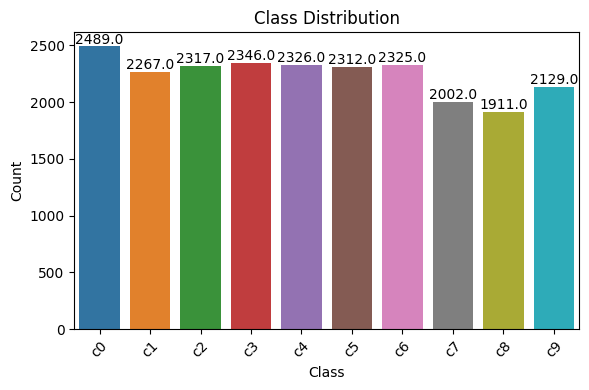

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv('/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv')


plt.figure(figsize=(6, 4))

ax = sns.countplot(x='classname', data=data)


plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')

plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')


plt.tight_layout()  
plt.show()


In [11]:
## reading the image using open cv
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

In [12]:
#/kaggle/input/state-farm-distracted-driver-detection/imgs/train
## collecting the train data in classwise

## /kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg
# no_of_classes=10
# img_rows = 224
# img_cols = 224
# train_images=[]
# train_labels=[]
# for i in range(10):
#     directory_path = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c"+str(i)
#     file_list = os.listdir(directory_path)
#     for filename in file_list:
#         full_path = os.path.join(directory_path, filename)
#         img = get_cv2_image(full_path, img_rows, img_cols, 3)
#         train_images.append(img)
#         train_labels.append(i)       

In [2]:
directory_path = "/kaggle/input/state-farm-distracted-driver-detection/imgs/train/"
SEED=1345
img_paths = []
img_labels = []

for label in os.listdir(directory_path):
    for image in os.listdir(directory_path+label):
        img_paths.append(directory_path+label+'/'+image)
        img_labels.append(label)

img_paths, img_labels = shuffle(img_paths, img_labels)

In [3]:
def image_df(img_path):
    classes = []
    class_paths = []
    files = os.listdir(img_path)
    for file in files:
        label_dir = os.path.join(img_path, file)
        label = os.listdir(label_dir)
        for image in label:
            image_path = os.path.join(label_dir, image)
            class_paths.append(image_path)
            classes.append(file)
    image_classes = pd.Series(classes, name='Class')
    image_paths = pd.Series(class_paths, name='Class Path')
    img_df = pd.concat([image_paths, image_classes], axis=1)
    return img_df

In [4]:
img_df = image_df('/kaggle/input/state-farm-distracted-driver-detection/imgs/train')

In [5]:
img_df.head()

,Class Path,Class
0,/kaggle/input/state-farm-distracted-driver-det...,c5
1,/kaggle/input/state-farm-distracted-driver-det...,c5
2,/kaggle/input/state-farm-distracted-driver-det...,c5
3,/kaggle/input/state-farm-distracted-driver-det...,c5
4,/kaggle/input/state-farm-distracted-driver-det...,c5


In [6]:
x_tr, x_test = train_test_split(img_df, test_size=0.2, random_state=42)

In [8]:
x_train, x_valid= train_test_split(x_tr, test_size=0.2, random_state=42)

In [9]:
x_train.head()

,Class Path,Class
16720,/kaggle/input/state-farm-distracted-driver-det...,c1
21626,/kaggle/input/state-farm-distracted-driver-det...,c0
12937,/kaggle/input/state-farm-distracted-driver-det...,c4
3078,/kaggle/input/state-farm-distracted-driver-det...,c7
1575,/kaggle/input/state-farm-distracted-driver-det...,c5


In [10]:
image_size = (224, 224)

# Training batch size
batch_size = 32

SEED=1345

train_datagen=ImageDataGenerator(rescale=1./255)

validation_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)


tr_gen = train_datagen.flow_from_dataframe(x_train, x_col='Class Path',
                                 y_col='Class',shuffle=True,
                                 target_size=image_size,seed = SEED,
                                 batch_size=32,
                                 class_mode ='categorical',)

valid_gen = validation_datagen.flow_from_dataframe(x_valid, x_col='Class Path',
                                    y_col='Class',
                                    target_size=image_size,seed = SEED,
                                    batch_size=32,
                                    class_mode ='categorical',)

ts_gen = test_datagen.flow_from_dataframe(x_test, x_col='Class Path',
                                y_col='Class',
                                 target_size=image_size,shuffle=False,
                                 seed = SEED,
                                 batch_size=32,
                                 class_mode ='categorical',)

Found 14351 validated image filenames belonging to 10 classes.
Found 3588 validated image filenames belonging to 10 classes.
Found 4485 validated image filenames belonging to 10 classes.


***VGG Network***

In [23]:
image_size = (224,224,3)
# Create an instance of the ResNet152 model
VGG19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=image_size, pooling=None
)

# Freeze the layers of the ResNet152 model
for layer in VGG19.layers:
    layer.trainable = False

# Create a new model with additional layers
model = Sequential([
    VGG19,
#     GlobalAveragePooling2D(),
#     BatchNormalization(),
    Flatten(),
    Dense(512, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(256, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(64, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(10, activation='softmax')  # Adjust the number of units based on your output classes
])
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

In [24]:
steps_per_epoch = tr_gen.samples // 32
validation_steps = valid_gen.samples // 32
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy',
                           mode='max', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(tr_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=5,verbose = 1,
                    validation_data=valid_gen,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/5
448/448 [==============================] - 76s 165ms/step - loss: 0.4783 - accuracy: 0.8746 - auc_4: 0.9832 - precision_4: 0.9414 - recall_4: 0.8253 - val_loss: 0.0922 - val_accuracy: 0.9729 - val_auc_4: 0.9988 - val_precision_4: 0.9764 - val_recall_4: 0.9693 - lr: 0.0010
Epoch 2/5
448/448 [==============================] - 57s 127ms/step - loss: 0.0569 - accuracy: 0.9834 - auc_4: 0.9992 - precision_4: 0.9856 - recall_4: 0.9815 - val_loss: 0.0625 - val_accuracy: 0.9805 - val_auc_4: 0.9986 - val_precision_4: 0.9818 - val_recall_4: 0.9782 - lr: 0.0010
Epoch 3/5
448/448 [==============================] - 60s 134ms/step - loss: 0.0393 - accuracy: 0.9892 - auc_4: 0.9994 - precision_4: 0.9904 - recall_4: 0.9879 - val_loss: 0.0441 - val_accuracy: 0.9888 - val_auc_4: 0.9993 - val_precision_4: 0.9897 - val_recall_4: 0.9880 - lr: 0.0010
Epoch 4/5
448/448 [==============================] - 59s 132ms/step - loss: 0.0522 - accuracy: 0.9829 - auc_4: 0.9992 - precision_4: 0.9845 - recall_4:

In [ ]:
figure , axis = plt.subplots(2,2,figsize=(5,5))


axis[0,0].plot(history.history['loss'] , label='train')
axis[0,0].plot(history.history['val_loss'] , label='val')
axis[0,0].set_title('Training/validation loss over Epochs')
axis[0,0].set_xlabel('Epochs')
axis[0,0].set_ylabel('loss')
axis[0,0].legend()


axis[1,0].plot(history.history['accuracy'], label='train')
axis[1,0].plot(history.history['val_accuracy'], label='val')
axis[1,0].set_title('Training/validation accuracy over Epochs')
axis[1,0].set_xlabel('epoch')
axis[1,0].set_ylabel('Accuracy')
axis[1,0].legend()

In [23]:
result = model.evaluate(ts_gen)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')

141/141 [==============================] - 19s 135ms/step - loss: 2891.2786 - accuracy: 0.9882 - auc: 0.9983 - precision: 0.9884 - recall: 0.9873
Test Loss = 2891.278564453125
Test Accuracy = 0.9881828427314758
Test AUC = 0.9982909560203552
Test Precision = 0.9883928298950195
Test Recall = 0.9872909784317017


In [12]:
image_size = (224,224,3)
# Create an instance of the ResNet152 model
MobileNetV2 = tf.keras.applications.MobileNetV2(
    include_top=False, weights="imagenet", input_shape=image_size, pooling=None
)

# Freeze the layers of the ResNet152 model
for layer in MobileNetV2.layers:
    layer.trainable = False

# Create a new model with additional layers
model = Sequential([
    MobileNetV2,
    GlobalAveragePooling2D(),
    BatchNormalization(),
#     Flatten(),
    Dense(512, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(256, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(64, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(10, activation='softmax')  # Adjust the number of units based on your output classes
])
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

In [13]:
steps_per_epoch = tr_gen.samples // 32
validation_steps = valid_gen.samples // 32
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy',
                           mode='max', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(tr_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,verbose = 1,
                    validation_data=valid_gen,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/10
448/448 [==============================] - 144s 306ms/step - loss: 0.3803 - accuracy: 0.8780 - auc_1: 0.9899 - precision_1: 0.9312 - recall_1: 0.8438 - val_loss: 0.1036 - val_accuracy: 0.9704 - val_auc_1: 0.9982 - val_precision_1: 0.9741 - val_recall_1: 0.9671 - lr: 0.0010
Epoch 2/10
448/448 [==============================] - 58s 130ms/step - loss: 0.0897 - accuracy: 0.9706 - auc_1: 0.9988 - precision_1: 0.9738 - recall_1: 0.9675 - val_loss: 0.0839 - val_accuracy: 0.9760 - val_auc_1: 0.9978 - val_precision_1: 0.9787 - val_recall_1: 0.9735 - lr: 0.0010
Epoch 3/10
448/448 [==============================] - 57s 126ms/step - loss: 0.0748 - accuracy: 0.9758 - auc_1: 0.9986 - precision_1: 0.9782 - recall_1: 0.9744 - val_loss: 0.1334 - val_accuracy: 0.9688 - val_auc_1: 0.9954 - val_precision_1: 0.9706 - val_recall_1: 0.9671 - lr: 0.0010
Epoch 4/10
448/448 [==============================] - 58s 130ms/step - loss: 0.0588 - accuracy: 0.9821 - auc_1: 0.9987 - precision_1: 0.9830 - reca

In [14]:
result = model.evaluate(ts_gen)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')

141/141 [==============================] - 37s 265ms/step - loss: 0.0750 - accuracy: 0.9813 - auc_1: 0.9977 - precision_1: 0.9826 - recall_1: 0.9808
Test Loss = 0.07503209263086319
Test Accuracy = 0.9812709093093872
Test AUC = 0.9977419376373291
Test Precision = 0.9825776219367981
Test Recall = 0.9808249473571777


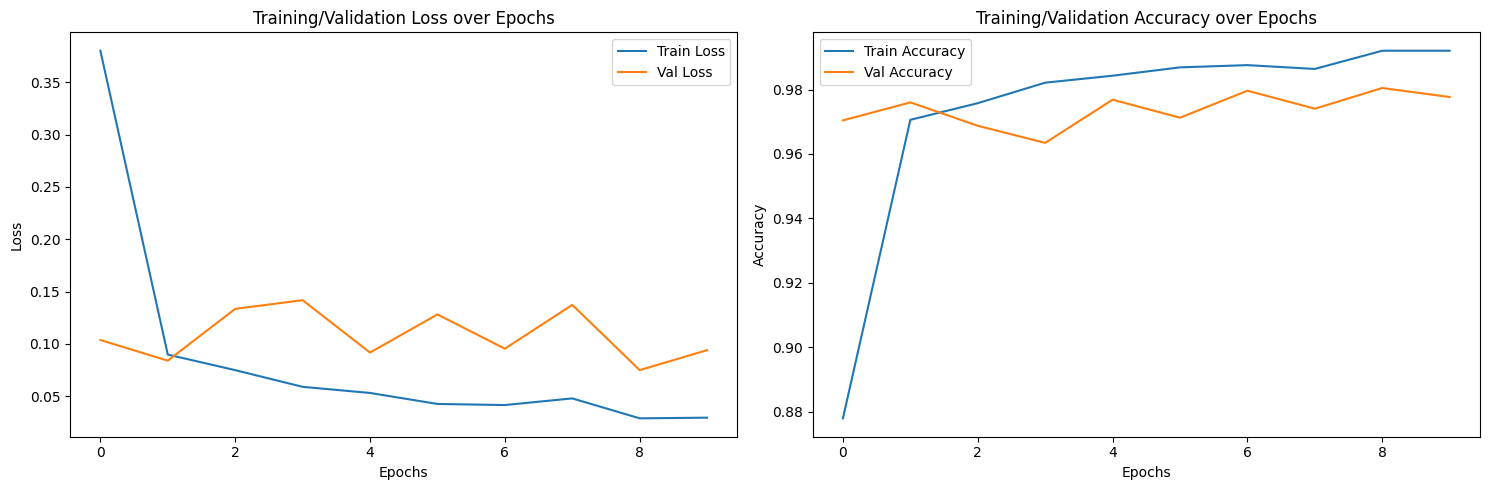

In [15]:
import matplotlib.pyplot as plt

# Create a subplot with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # One row, two columns

# Plot training and validation loss on the first subplot (axes[0])
axes[0].plot(history.history['loss'], label='Train Loss')  # Training loss
axes[0].plot(history.history['val_loss'], label='Val Loss')  # Validation loss
axes[0].set_title('Training/Validation Loss over Epochs')  # Set plot title
axes[0].set_xlabel('Epochs')  # X-axis label
axes[0].set_ylabel('Loss')  # Y-axis label
axes[0].legend()  # Add legend

# Plot training and validation accuracy on the second subplot (axes[1])
axes[1].plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')  # Validation accuracy
axes[1].set_title('Training/Validation Accuracy over Epochs')  # Set plot title
axes[1].set_xlabel('Epochs')  # X-axis label
axes[1].set_ylabel('Accuracy')  # Y-axis label
axes[1].legend()  # Add legend

# Adjust layout to prevent overlap
plt.tight_layout()  # Ensures proper spacing between subplots

# Show the plot
plt.show()  # Display the figure with both subplots

In [10]:
image_size = (224,224,3)
# Create an instance of the DenseNet201 model
InceptionResNetV2 = tf.keras.applications.InceptionResNetV2(
    include_top=False, weights="imagenet", input_shape=image_size, pooling=None
)

# Freeze the layers of the ResNet152 model
for layer in InceptionResNetV2.layers:
    layer.trainable = False

# Create a new model with additional layers
model = Sequential([
    InceptionResNetV2,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(256, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(64, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(10, activation='softmax')  # Adjust the number of units based on your output classes
])
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

219055592/219055592 [==============================] - 8s 0us/step


In [11]:
steps_per_epoch = tr_gen.samples // 32
validation_steps = valid_gen.samples // 32
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy',
                           mode='max', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(tr_gen,
                    steps_per_epoch=len(tr_gen),
                    epochs=10,verbose = 1,
                    validation_data=valid_gen,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/10
449/449 [==============================] - 162s 326ms/step - loss: 0.6444 - accuracy: 0.7943 - auc: 0.9739 - precision: 0.8644 - recall: 0.7416 - val_loss: 0.2624 - val_accuracy: 0.9272 - val_auc: 0.9944 - val_precision: 0.9436 - val_recall: 0.9054 - lr: 0.0010
Epoch 2/10
449/449 [==============================] - 67s 148ms/step - loss: 0.2436 - accuracy: 0.9219 - auc: 0.9942 - precision: 0.9360 - recall: 0.9125 - val_loss: 0.2779 - val_accuracy: 0.9174 - val_auc: 0.9925 - val_precision: 0.9311 - val_recall: 0.9085 - lr: 0.0010
Epoch 3/10
449/449 [==============================] - 68s 152ms/step - loss: 0.1836 - accuracy: 0.9429 - auc: 0.9960 - precision: 0.9499 - recall: 0.9355 - val_loss: 0.1883 - val_accuracy: 0.9459 - val_auc: 0.9952 - val_precision: 0.9531 - val_recall: 0.9408 - lr: 0.0010
Epoch 4/10
449/449 [==============================] - 68s 151ms/step - loss: 0.1295 - accuracy: 0.9580 - auc: 0.9975 - precision: 0.9634 - recall: 0.9549 - val_loss: 0.1797 - val_accu

In [12]:
result = model.evaluate(ts_gen)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')
print(f'Test Recall = {test_rec}')

141/141 [==============================] - 35s 246ms/step - loss: 0.1370 - accuracy: 0.9637 - auc: 0.9955 - precision: 0.9677 - recall: 0.9610
Test Loss = 0.1369774341583252
Test Accuracy = 0.9636566042900085
Test AUC = 0.9955263137817383
Test Precision = 0.9676694869995117
Test Recall = 0.9609810709953308


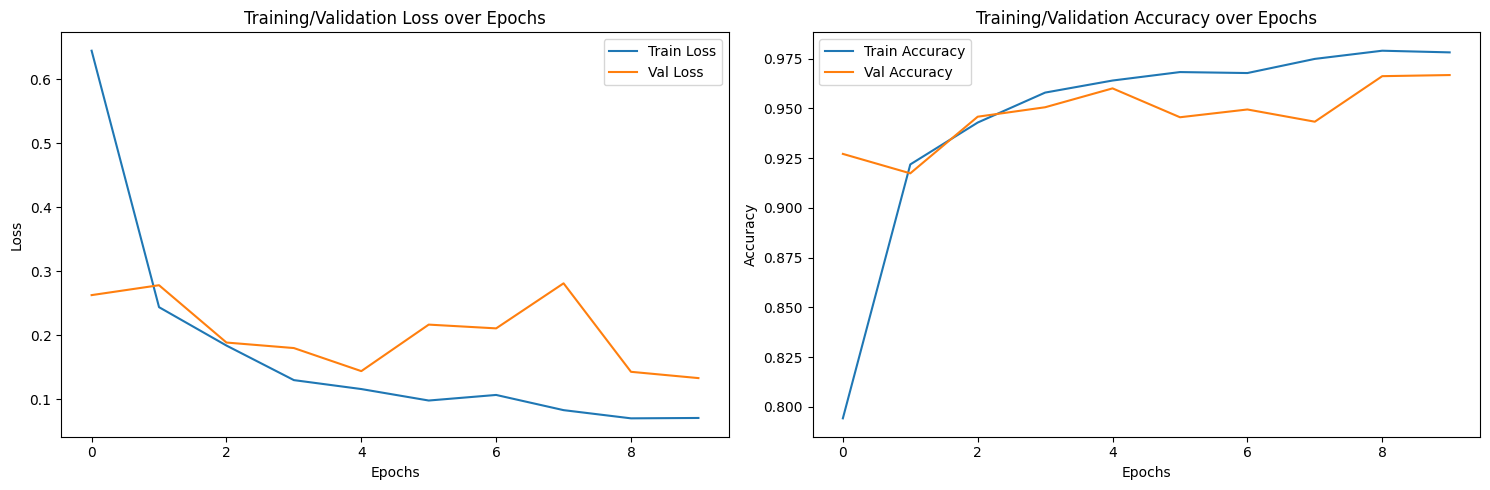

In [13]:
import matplotlib.pyplot as plt

# Create a subplot with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # One row, two columns

# Plot training and validation loss on the first subplot (axes[0])
axes[0].plot(history.history['loss'], label='Train Loss')  # Training loss
axes[0].plot(history.history['val_loss'], label='Val Loss')  # Validation loss
axes[0].set_title('Training/Validation Loss over Epochs')  # Set plot title
axes[0].set_xlabel('Epochs')  # X-axis label
axes[0].set_ylabel('Loss')  # Y-axis label
axes[0].legend()  # Add legend

# Plot training and validation accuracy on the second subplot (axes[1])
axes[1].plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')  # Validation accuracy
axes[1].set_title('Training/Validation Accuracy over Epochs')  # Set plot title
axes[1].set_xlabel('Epochs')  # X-axis label
axes[1].set_ylabel('Accuracy')  # Y-axis label
axes[1].legend()  # Add legend

# Adjust layout to prevent overlap
plt.tight_layout()  # Ensures proper spacing between subplots

# Show the plot
plt.show()  # Display the figure with both subplots


In [3]:
total_params = sum(p.numel() for p in model.Param())
print(f"Total parameters: {total_params}")


SyntaxError: '(' was never closed (3682998383.py, line 1)

In [11]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201

# Load pre-trained DenseNet201 model
model = DenseNet201(weights='imagenet', include_top=True)

# Get model summary
# model.summary()



82524592/82524592 [==============================] - 1s 0us/step


In [12]:
image_size = (224,224,3)
# Create an instance of the DenseNet201 model
DenseNet201 = tf.keras.applications.DenseNet201(
    include_top=False, weights="imagenet", input_shape=image_size, pooling=None
)

# Freeze the layers of the DenseNet201 model
for layer in DenseNet201.layers:
    layer.trainable = False

# Create a new model with additional layers
model = Sequential([
    DenseNet201,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.2),  # Add dropout layer with 50% dropout rate
    Dense(256, activation='relu'),
    Dropout(0.2),  # Add dropout layer with 50% dropout rate
    Dense(64, activation='relu'),
#     Dropout(0.5),  # Add dropout layer with 50% dropout rate
    Dense(10, activation='softmax')  # Adjust the number of units based on your output classes
])
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall()
    ]
)

74836368/74836368 [==============================] - 0s 0us/step


In [13]:
steps_per_epoch = tr_gen.samples // 32
validation_steps = valid_gen.samples // 32
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_accuracy',
                           mode='max', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(tr_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=10,verbose = 1,
                    validation_data=valid_gen,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/10
448/448 [==============================] - 186s 377ms/step - loss: 0.4306 - accuracy: 0.8601 - auc: 0.9880 - precision: 0.9249 - recall: 0.8158 - val_loss: 0.1052 - val_accuracy: 0.9665 - val_auc: 0.9988 - val_precision: 0.9721 - val_recall: 0.9621 - lr: 0.0010
Epoch 2/10
448/448 [==============================] - 63s 141ms/step - loss: 0.1136 - accuracy: 0.9619 - auc: 0.9978 - precision: 0.9672 - recall: 0.9584 - val_loss: 0.0637 - val_accuracy: 0.9799 - val_auc: 0.9993 - val_precision: 0.9813 - val_recall: 0.9785 - lr: 0.0010
Epoch 3/10
448/448 [==============================] - 62s 139ms/step - loss: 0.0806 - accuracy: 0.9742 - auc: 0.9987 - precision: 0.9766 - recall: 0.9717 - val_loss: 0.0493 - val_accuracy: 0.9835 - val_auc: 0.9991 - val_precision: 0.9846 - val_recall: 0.9821 - lr: 0.0010
Epoch 4/10
448/448 [==============================] - 62s 139ms/step - loss: 0.0577 - accuracy: 0.9809 - auc: 0.9991 - precision: 0.9830 - recall: 0.9800 - val_loss: 0.0621 - val_accu

In [14]:
result = model.evaluate(ts_gen)
test_loss = result[0]
test_accuracy = result[1]
test_AUC = result[2]
test_pre = result[3]
test_rec = result[4]
print(f'Test Loss = {test_loss}')
print(f'Test Accuracy = {test_accuracy}')
print(f'Test AUC = {test_AUC}')
print(f'Test Precision = {test_pre}')


141/141 [==============================] - 45s 322ms/step - loss: 0.0430 - accuracy: 0.9889 - auc: 0.9983 - precision: 0.9902 - recall: 0.9882
Test Loss = 0.043012913316488266
Test Accuracy = 0.9888517260551453
Test AUC = 0.9983100891113281
Test Precision = 0.9901698231697083


In [15]:
model.save('denseNet.h5')

In [20]:
Y_pred=model.predict(ts_gen)

141/141 [==============================] - 20s 116ms/step


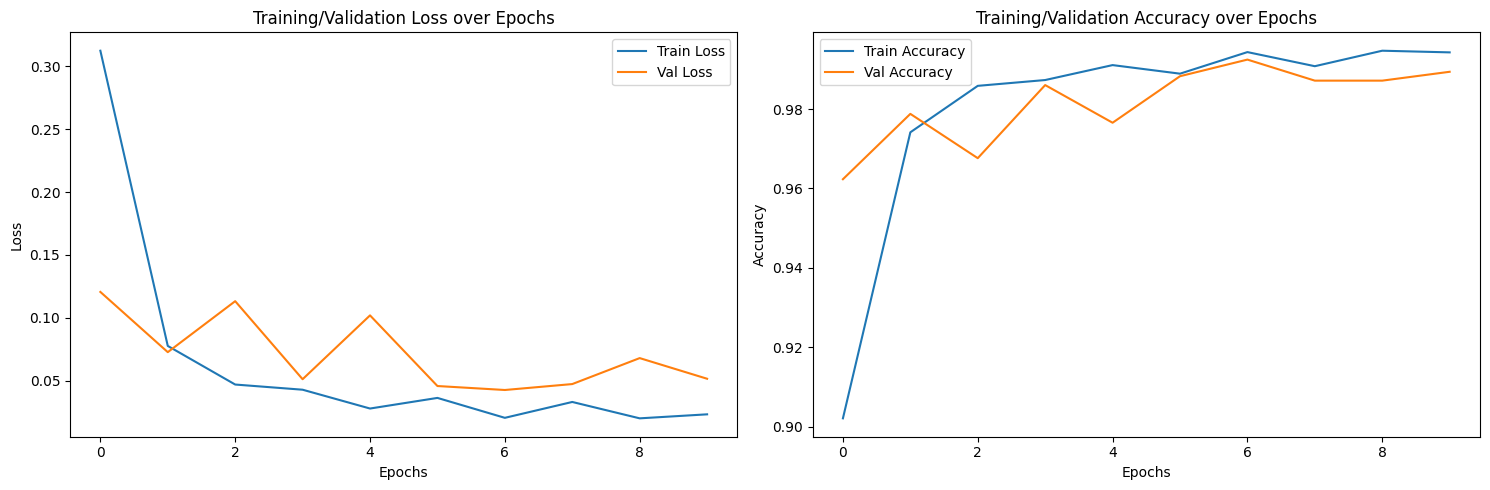

In [17]:
import matplotlib.pyplot as plt

# Create a subplot with one row and two columns
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # One row, two columns

# Plot training and validation loss on the first subplot (axes[0])
axes[0].plot(history.history['loss'], label='Train Loss')  # Training loss
axes[0].plot(history.history['val_loss'], label='Val Loss')  # Validation loss
axes[0].set_title('Training/Validation Loss over Epochs')  # Set plot title
axes[0].set_xlabel('Epochs')  # X-axis label
axes[0].set_ylabel('Loss')  # Y-axis label
axes[0].legend()  # Add legend

# Plot training and validation accuracy on the second subplot (axes[1])
axes[1].plot(history.history['accuracy'], label='Train Accuracy')  # Training accuracy
axes[1].plot(history.history['val_accuracy'], label='Val Accuracy')  # Validation accuracy
axes[1].set_title('Training/Validation Accuracy over Epochs')  # Set plot title
axes[1].set_xlabel('Epochs')  # X-axis label
axes[1].set_ylabel('Accuracy')  # Y-axis label
axes[1].legend()  # Add legend

# Adjust layout to prevent overlap
plt.tight_layout()  # Ensures proper spacing between subplots

# Show the plot
plt.show()  # Display the figure with both subplots


In [22]:
Y_pred=model.predict(valid_gen)
y_pred=[]
[y_pred.append(np.argmax(l)) for l in Y_pred ]

113/113 [==============================] - 17s 150ms/step


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [ ]:
y_pred=[]
[y_pred.append(np.argmax(l)) for l in Y_pred ]

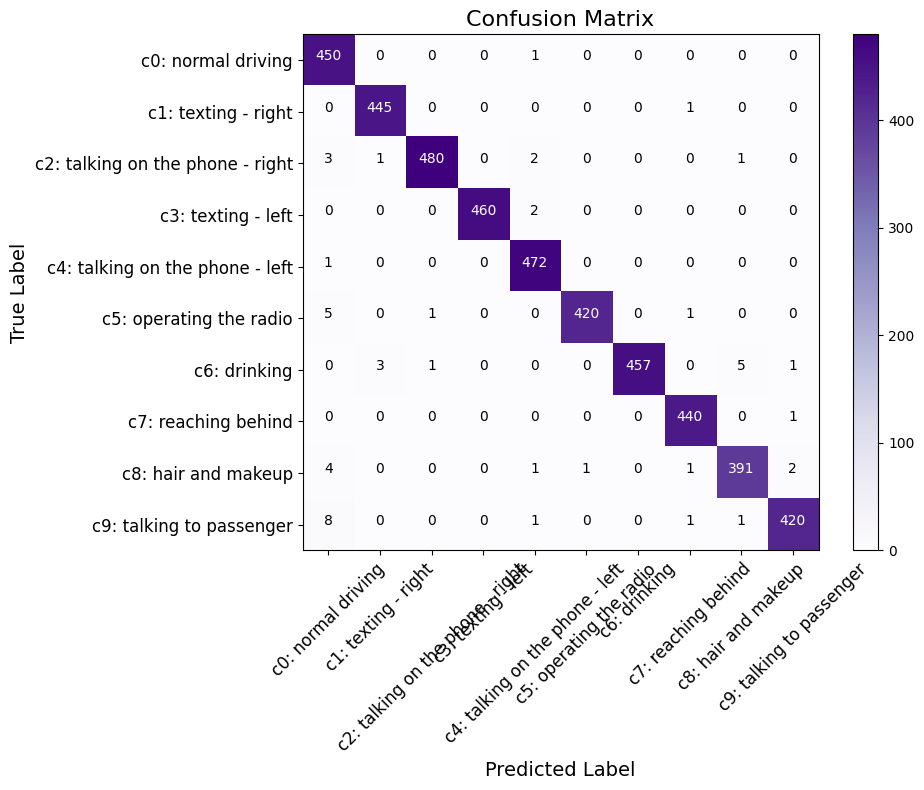

In [24]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

class_names=["c0: normal driving",
"c1: texting - right",
"c2: talking on the phone - right",
"c3: texting - left",
"c4: talking on the phone - left",
"c5: operating the radio",
"c6: drinking",
"c7: reaching behind",
"c8: hair and makeup",
"c9: talking to passenger"]

test_label=ts_gen.classes

def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()  # Add a color bar for reference

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)  # X-axis labels
    plt.yticks(tick_marks, classes, fontsize=12)  # Y-axis labels

    # Format for text inside the confusion matrix cells
    fmt = 'd'  # Display numbers as integers

    # Add text in each cell with appropriate color based on value
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, 
            i, 
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black",
            fontsize=10  # Text size
        )

    plt.ylabel('True Label', fontsize=14)  # Y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # X-axis label
    plt.tight_layout()  # Ensure proper spacing to avoid overlaps

# Example confusion matrix
# Replace `test_label` with your true labels and `y_pred` with your predictions
# test_label = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Example true labels
# y_pred = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]  # Example predicted labels

# Compute the confusion matrix
cm = confusion_matrix(test_label, y_pred)

# Define class names (adjust to your dataset)
# class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

# Plot the confusion matrix with custom class names
plot_confusion_matrix(cm, class_names)

# Show the plot
plt.show()

In [26]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       451
           1       0.99      1.00      0.99       446
           2       1.00      0.99      0.99       487
           3       1.00      1.00      1.00       462
           4       0.99      1.00      0.99       473
           5       1.00      0.98      0.99       427
           6       1.00      0.98      0.99       467
           7       0.99      1.00      0.99       441
           8       0.98      0.98      0.98       400
           9       0.99      0.97      0.98       431

    accuracy                           0.99      4485
   macro avg       0.99      0.99      0.99      4485
weighted avg       0.99      0.99      0.99      4485



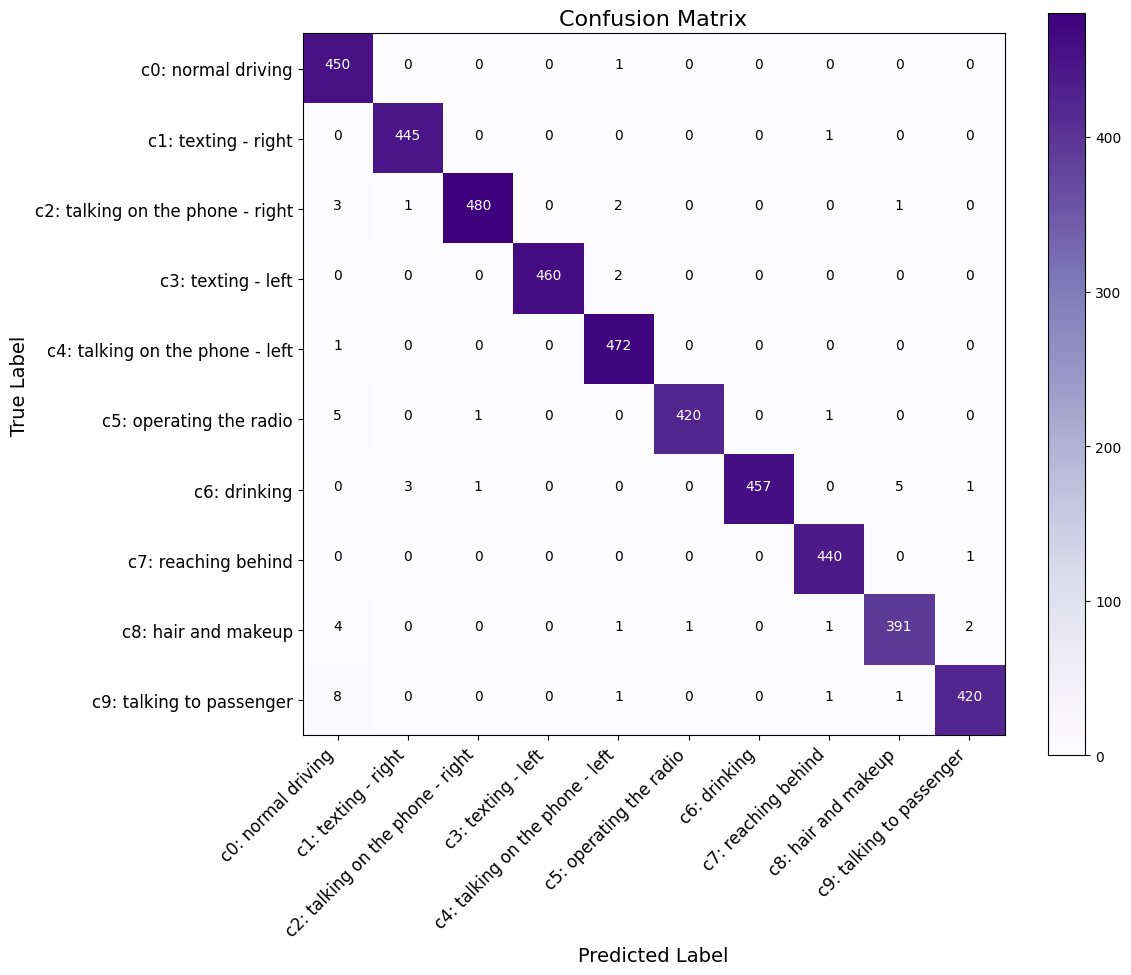

In [25]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import numpy as np

# Class names
class_names = [
    "c0: normal driving",
    "c1: texting - right",
    "c2: talking on the phone - right",
    "c3: texting - left",
    "c4: talking on the phone - left",
    "c5: operating the radio",
    "c6: drinking",
    "c7: reaching behind",
    "c8: hair and makeup",
    "c9: talking to passenger"
]

# Assuming test_label and y_pred are defined
# test_label = [...]
# y_pred = [...]

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm, classes, cmap=plt.cm.Purples):
    plt.figure(figsize=(12, 10))  # Increased figure size for better readability
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion Matrix', fontsize=16)
    plt.colorbar()  # Add a color bar for reference

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, ha='right', fontsize=12)  # Rotate x-axis labels
    plt.yticks(tick_marks, classes, fontsize=12)  # y-axis labels

    # Format for text inside the confusion matrix cells
    fmt = 'd'  # Display numbers as integers

    # Add text in each cell with appropriate color based on value
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j, 
            i, 
            format(cm[i, j], fmt),
            horizontalalignment="center",
            color="white" if cm[i, j] > cm.max() / 2 else "black",
            fontsize=10  # Text size
        )

    plt.ylabel('True Label', fontsize=14)  # Y-axis label
    plt.xlabel('Predicted Label', fontsize=14)  # X-axis label
    plt.tight_layout()  # Ensure proper spacing to avoid overlaps

# Compute the confusion matrix
cm = confusion_matrix(test_label, y_pred)

# Plot the confusion matrix with custom class names
plot_confusion_matrix(cm, class_names)

# Show the plot
plt.show()


In [24]:
from sklearn.metrics import confusion_matrix, classification_report
# Compute the classification report
report = classification_report(test_label, y_pred)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.11      0.11       420
           1       0.13      0.13      0.13       371
           2       0.08      0.08      0.08       373
           3       0.11      0.11      0.11       379
           4       0.10      0.11      0.11       366
           5       0.09      0.09      0.09       384
           6       0.11      0.11      0.11       370
           7       0.11      0.12      0.11       293
           8       0.09      0.09      0.09       311
           9       0.09      0.09      0.09       321

    accuracy                           0.10      3588
   macro avg       0.10      0.10      0.10      3588
weighted avg       0.10      0.10      0.10      3588

